In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy

from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from wordcloud import WordCloud
from operator import itemgetter

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')
#ni untuk inggris bang

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [69]:
df_train = pd.read_csv("/kaggle/input/kcvanguard-deep-learning-assignment/train-reviews-gmaps.csv")
df_test = pd.read_csv("/kaggle/input/kcvanguard-deep-learning-assignment/test-review-gmaps-new.csv")

df_train.info()
df_train.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20999 entries, 0 to 20998
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       20999 non-null  int64 
 1   reviews  20999 non-null  object
 2   label    20999 non-null  object
dtypes: int64(1), object(2)
memory usage: 492.3+ KB


,id,reviews,label
20994,20995,masakan nya..sedap...,Positive
20995,20996,super duper worth it👍🏻,Positive
20996,20997,+ Tempat dekat sama bandara dan tempat oleh-ol...,Positive
20997,20998,"Menu sarapan terpopuler di Bangkalan, lauknya ...",Positive
20998,20999,Nice dinning place. It always improve. Like no...,Positive


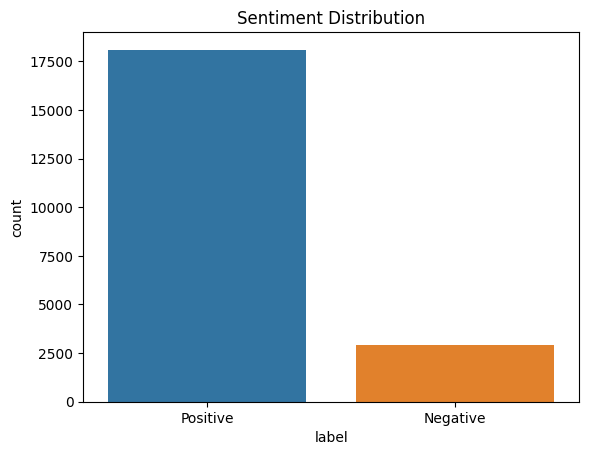

In [70]:
sns.countplot(x=df_train["label"])
plt.title("Sentiment Distribution")
plt.show()

In [71]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train[['reviews']], 
    df_train['label'], 
    test_size=0.2,
    stratify=df_train['label'],
    random_state=42
)

In [72]:
df_train_split = pd.DataFrame({'reviews': X_train['reviews'], 'label': y_train})
df_val = pd.DataFrame({'reviews': X_val['reviews'], 'label': y_val})

In [73]:
# Separate positive and negative reviews (only training data)
df_pos_train = df_train_split[df_train_split["label"] == "Positive"]
df_neg_train = df_train_split[df_train_split["label"] == "Negative"]

In [74]:
from sklearn.utils import resample
# Resample to match the higher class (positive in this case)
df_neg_sampled = resample(df_neg_train, replace=True, n_samples=len(df_pos_train), random_state=42)  
df_train_balanced = pd.concat([df_neg_sampled, df_pos_train])

print(df_train_balanced["label"].value_counts())
print(df_val["label"].value_counts())

label
Negative    14477
Positive    14477
Name: count, dtype: int64
label
Positive    3620
Negative     580
Name: count, dtype: int64


In [75]:
stop_words = {"ny", "yg","aja", "sih", "nih", "nya", "ya", "deh" ,"dong","kalo"
                         "kalau", "kayak", "kok","lah","loh","tuh","sama", "sampe", "di","ini","yang","dan","juga"}

In [77]:
def preprocess_text(text):
    compound_phrases = {"gak enak", "ga enak", "kurang nyaman", "tidak enak", "kurang enak", "tidak recommended", "ga sesuai", "sangat lama", "lama sekali"
                     , "kurang baik", "gak bagus", "ga bagus"}
    for phrase in compound_phrases:
        text = text.replace(phrase, phrase.replace(" ", "_"))
    
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()

    doc = nlp(text)
    # no stopwords, no punctuation, lemmatized yohohohoh
    processed_tokens = [token.lemma_ for token in doc 
                         if not token.is_stop
                         and token.text not in stop_words
                         and not token.is_punct 
                         and token.lemma_.strip()]
    
    return " ".join(processed_tokens)


In [78]:
df_train_balanced['processed_reviews'] = df_train_balanced['reviews'].apply(preprocess_text)
df_val['processed_reviews'] = df_val['reviews'].apply(preprocess_text)
df_test['processed_reviews'] = df_test['reviews'].apply(preprocess_text)

In [79]:
df_train_balanced.drop(columns = ["reviews"], inplace =True)
df_val.drop(columns=["reviews"], inplace=True)
df_test.drop(columns = ["reviews"], inplace =True)

In [80]:
df_train_balanced.head()

,label,processed_reviews
5518,Negative,enak rasanya
14140,Negative,rasa lumayan meskipun bumbu kurang empuk tapi ...
614,Negative,makanannya enak semua tapi pelayananya kurang ...
2738,Negative,tasteless luke warm food come ifthar book plac...
17711,Negative,makanannya enak harga terjangkau cocok untuk s...


In [81]:
tokenizer = Tokenizer()

# Tokenize and count word frequency for positive reviews
tokenizer.fit_on_texts(df_train_balanced[df_train_balanced["label"] == "Positive"]["processed_reviews"])
positive_words = sorted(tokenizer.word_counts.items(), key=itemgetter(1), reverse=True)
positive_words = [(word, count) for word, count in positive_words if word not in stop_words]
print("Most Frequent Words in Positive Reviews:\n", positive_words[:25])

# Tokenize and count word frequency for negative reviews
tokenizer.fit_on_texts(df_train_balanced[df_train_balanced["label"] == "Negative"]["processed_reviews"])
negative_words = sorted(tokenizer.word_counts.items(), key=itemgetter(1), reverse=True)
negative_words = [(word, count) for word, count in negative_words if word not in stop_words]
print("Most Frequent Words in Negative Reviews:\n", negative_words[:25])

Most Frequent Words in Positive Reviews:
 [('enak', 6113), ('untuk', 3880), ('ada', 3724), ('tidak', 3601), ('tempat', 3338), ('bagus', 3013), ('makan', 2742), ('dengan', 2569), ('harga', 2387), ('makanan', 2351), ('banget', 2351), ('menu', 2339), ('tapi', 2175), ('bisa', 2152), ('kalau', 1972), ('banyak', 1929), ('rasa', 1834), ('food', 1797), ('tempatnya', 1791), ('saya', 1779), ('nyaman', 1743), ('buat', 1717), ('👍', 1683), ('place', 1643), ('dari', 1574)]
Most Frequent Words in Negative Reviews:
 [('tidak', 15413), ('enak', 9193), ('ada', 8854), ('untuk', 8374), ('saya', 7675), ('tapi', 6403), ('makan', 6277), ('tempat', 5843), ('makanan', 5662), ('dengan', 5254), ('bagus', 5112), ('sudah', 5025), ('kalau', 4725), ('harga', 4649), ('banget', 4479), ('menu', 4459), ('rasa', 4411), ('bisa', 4278), ('kurang', 3956), ('food', 3930), ('karena', 3895), ('banyak', 3852), ('lagi', 3743), ('nasi', 3628), ('saja', 3585)]


In [82]:
#Ensure processed_reviews is of type string
df_train_balanced['processed_reviews'] = df_train_balanced['processed_reviews'].astype(str)
df_val['processed_reviews'] = df_val['processed_reviews'].astype(str)
df_test['processed_reviews'] = df_test['processed_reviews'].astype(str)

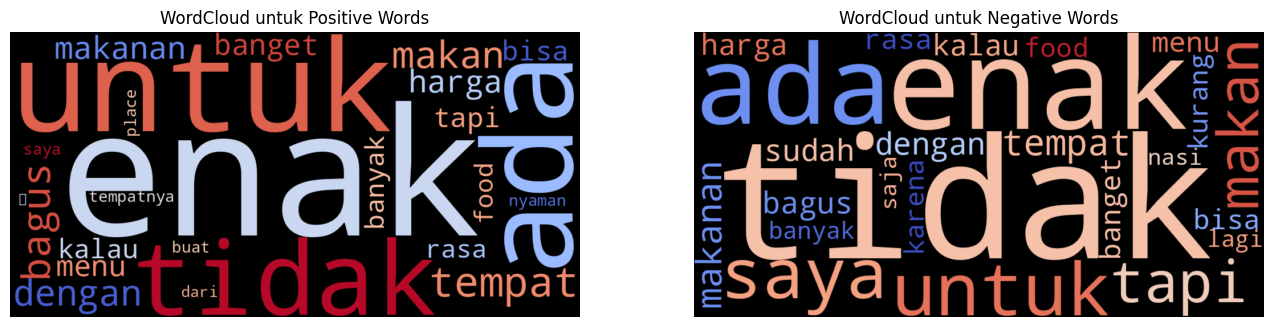

In [83]:
from wordcloud import WordCloud

wc = WordCloud(max_words=5000,
               min_font_size=10,
               height=500,
               width=1000,
               colormap='coolwarm_r',
               repeat=False)
plt.figure(figsize=(25,15))

plt.subplot(3,3,1)
wc.generate_from_frequencies(frequencies=dict(positive_words[:25]))
plt.imshow(wc, interpolation="bilinear")
plt.title("WordCloud untuk Positive Words")
plt.axis("off")

plt.subplot(3,3,2)
wc.generate_from_frequencies(frequencies=dict(negative_words[:25]))
plt.imshow(wc, interpolation="bilinear")
plt.title("WordCloud untuk Negative Words")
plt.axis("off")

plt.show()

In [84]:
#Load IndoBERT Tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

#Load IndoBERT Model
bert_model = AutoModelForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased", 
    num_labels=2  #Positive/Negative
)

bert_model.config.hidden_dropout_prob = 0.3
bert_model.config.attention_probs_dropout_prob = 0.3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
max_length = 128

# Tokenize training data using IndoBERT tokenizer
train_encodings = bert_tokenizer(
    df_train_balanced['processed_reviews'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize validation data separately
val_encodings = bert_tokenizer(
    df_val['processed_reviews'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

In [86]:
#Convert labels to Numericallllls
label_dict = {"Negative": 0, "Positive": 1}
train_labels = np.array([label_dict[label] for label in df_train_balanced['label']])
val_labels = np.array([label_dict[label] for label in df_val['label']])

In [87]:
# Create PyTorch dataset
train_dataset = TensorDataset(
    train_encodings['input_ids'], #tokenized processed_ripiw
    train_encodings['attention_mask'],
    torch.tensor(train_labels)
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_labels)
)

In [88]:
# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

In [89]:
# Set up the optimizer
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5, weight_decay = 0.01)

In [90]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
bert_model.to(device)

#USE GPU Bro

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [91]:
# Training loop
epochs = 4
print("Training IndoBERT model...:)")
for epoch in range(epochs):
    print(f'======== Epoch {epoch+1} / {epochs} ========')
    
    # Training
    bert_model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []
    train_pbar = tqdm(train_dataloader, desc="Training")
    
    for batch in train_pbar:
        # Add batch to device
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_mask, labels = batch
        
        # Clear gradients
        bert_model.zero_grad()
        
        # Forward pass
        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_train_preds.extend(preds)
        all_train_labels.extend(labels)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = (np.array(all_train_preds) == np.array(all_train_labels)).mean() 
    print(f"Average training loss: {avg_train_loss}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    # Validation
    bert_model.eval()
    total_val_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(val_dataloader, desc="Validation"):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_mask, labels = batch
        
        with torch.no_grad():
            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
        
        loss = outputs.loss
        total_val_loss += loss.item()
        
        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels)
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"Validation Loss: {avg_val_loss}")
    print(f"Validation Accuracy: {accuracy:.4f}")

Training IndoBERT model...:)
======== Epoch 1 / 4 ========


Training: 100%|██████████| 1810/1810 [05:47<00:00,  5.22it/s]


Average training loss: 0.3982379781421871
Training Accuracy: 0.8200


Validation: 100%|██████████| 263/263 [00:14<00:00, 18.67it/s]


Validation Loss: 0.40899112140724414
Validation Accuracy: 0.8450
======== Epoch 2 / 4 ========


Training: 100%|██████████| 1810/1810 [05:47<00:00,  5.21it/s]


Average training loss: 0.21486780788049678
Training Accuracy: 0.9160


Validation: 100%|██████████| 263/263 [00:14<00:00, 18.64it/s]


Validation Loss: 0.31739022030704034
Validation Accuracy: 0.9036
======== Epoch 3 / 4 ========


Training: 100%|██████████| 1810/1810 [05:47<00:00,  5.22it/s]


Average training loss: 0.12321235391514591
Training Accuracy: 0.9534


Validation: 100%|██████████| 263/263 [00:14<00:00, 18.65it/s]


Validation Loss: 0.4738080578186893
Validation Accuracy: 0.8614
======== Epoch 4 / 4 ========


Training: 100%|██████████| 1810/1810 [05:47<00:00,  5.21it/s]


Average training loss: 0.08681200815352498
Training Accuracy: 0.9666


Validation: 100%|██████████| 263/263 [00:14<00:00, 18.66it/s]

Validation Loss: 0.4515279024217929
Validation Accuracy: 0.8955


In [92]:
# Save the model
bert_model.save_pretrained('./indobert_sentiment_model')
bert_tokenizer.save_pretrained('./indobert_sentiment_model')

('./indobert_sentiment_model/tokenizer_config.json',
 './indobert_sentiment_model/special_tokens_map.json',
 './indobert_sentiment_model/vocab.txt',
 './indobert_sentiment_model/added_tokens.json',
 './indobert_sentiment_model/tokenizer.json')

In [93]:
print("Generating predictions for test data...")
bert_model.eval()
test_predictions = []

Generating predictions for test data...


In [94]:
# Tokenize test data
test_encodings = bert_tokenizer(
    df_test['processed_reviews'].tolist(),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask']
)

test_dataloader = DataLoader(test_dataset, batch_size=32)

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Predicting"):
        batch = tuple(b.to(device) for b in batch)
        input_ids, attention_mask = batch
        
        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        test_predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())


Predicting: 100%|██████████| 127/127 [00:13<00:00,  9.55it/s]


In [95]:
# Convert back to labels
label_map = {0: "Negative", 1: "Positive"}
df_test['label'] = [label_map[pred] for pred in test_predictions]

In [96]:
# Create submission file
df_submission = df_test[['id', 'label']]
df_submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
